# Kr DD profiles

J. A Hernando, C. Herves

March 2022

In [1]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
from   scipy             import stats

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import nana.bclouds.bclouds      as bc
#import hipy.hfit         as hfit

import invisible_cities.io.dst_io as dio

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed Apr 20 16:58:32 2022


In [5]:
#import os
import re
import glob

from collections import namedtuple

## Code

In [6]:
def generate_kr_toy(size = 100000, length = 100., e0 = 41.5, tau = 0.1, beta = 0.2, sigma = 0.05):
    """
    Generate Kr data: x, y, z, enegy
    """
    
    ts = stats.uniform.rvs(0, length, size = size)
    xs = stats.uniform.rvs(0, length, size = size) - 0.5 * length
    ys = stats.uniform.rvs(0, length, size = size) - 0.5 * length
    es = (1. - tau * ts/length) * stats.norm.rvs(loc = e0, scale = e0 * sigma, size = size)
    rs = np.sqrt(xs ** 2 + ys ** 2)
    er = es * (1 - beta * (2 * rs / length) ** 2)
    
    sel = rs < length/2
    df = {'dtime' : ts[sel], 'x': xs[sel], 'y': ys[sel], 'energy': er[sel]}
    return pd.DataFrame(df)
                                               

In [7]:

KrMap = namedtuple('KrMap', ('counts', 'mean', 'std', 'chi2', 'pvalue', 'bin_centers', 'bin_edges', 
                             'bin_indices', 'residuals'))

def _residuals(values, mean, std, ibins):
    
    def _res(val, idx):
        _res  = val - mean[idx]
        _std  = float(std[idx])
        if _std > 0: _res = _res/_std
        return _res
    zbins = ibins if len(ibins) == len(values) else zip(*ibins)
    res = [_res(val, idx) for val, idx in zip(values, zbins)]
    return np.array(res, float)
 
def _correction(values, mean, ibins, e0 = 41.5):
 
    def _coor(val, idx):
        factor = mean[idx]
        factor = e0 / factor if factor > 0 else 0.
        return factor * val

    zbins = ibins if len(ibins) == len(values) else zip(*ibins)
    corvalues = [_coor(val, idx) for val, idx in zip(values, zbins)]
    return np.array(corvalues, float)


def compute_krmap(coors, energy, bins = 20, ncounts_min = 3):
    """
    Compute KrMap
    """
    
    counts, ebins, ibins = stats.binned_statistic_dd(coors, energy, bins = bins, statistic = 'count',
                                                 expand_binnumbers = True)    
    ibins = [b-1 for b in ibins]

    mean, _, _  = stats.binned_statistic_dd(coors, energy, bins = bins, statistic = 'mean')
    
    std, _ , _  =  stats.binned_statistic_dd(coors, energy, bins = bins, statistic = 'std')

    res         = _residuals(energy, mean, std, ibins)    
    chi2, _ , _ = stats.binned_statistic_dd(coors, res * res, bins = bins, statistic = 'sum')
    sf          = stats.chi2.sf(chi2, counts)
    
    pvalue      = lambda x : stats.shapiro(x)[1] if (len(x) > 3) else 0.
    pval, _, _  = stats.binned_statistic_dd(coors, energy, bins = bins, statistic = pvalue)
        
    cbins       = [0.5 * (x[1:] + x[:-1]) for x in ebins]
    
    return KrMap(counts, mean, std, chi2, pval, cbins, ebins, ibins, res)


def krmap_correction(coors, energy, krmap, e0 = 41.5):
    """
    Apply Kr Map correction
    """
    
    mean  = krmap.mean
    ebins = krmap.bin_edges
    
    _, _, ibins = stats.binned_statistic_dd(coors, energy, bins = bins, statistic = 'count',
                                                 expand_binnumbers = True)
    ibins = [b-1 for b in ibins]
    
    cor_energy = _correction(energy, mean, ibins)
    
    return cor_energy
    

In [8]:
def plot_data(df):
    """
    Plot Kr Data
    """
    canvas = pltext.canvas(6, 2)
    canvas(1)
    pltext.hist(df.dtime, 100);
    plt.xlabel('drift time (ms)')
    canvas(2)
    pltext.hist(df.x, 100);
    plt.xlabel('x (mm)')
    canvas(3)
    pltext.hist(df.y, 100);
    plt.xlabel('y (mm)')
    canvas(4)
    pltext.hist(df.energy, 100);
    plt.xlabel('energy (keV)')
    canvas(5)
    plt.hist2d(df.dtime, df.energy, (20, 20))
    plt.xlabel('drift time (ms)'); plt.ylabel('energy (keV)')
    plt.colorbar();
    canvas(6)
    mean, ebins, _  = stats.binned_statistic_dd((df.x, df.y), df.energy, bins = 20 , statistic = 'mean')
    cbins = [0.5 * (b[1:] + b[:-1]) for b in ebins]
    mesh = np.meshgrid(*cbins)
    plt.hist2d(mesh[0].ravel(), mesh[1].ravel(), bins = ebins, weights = mean.T.ravel())
    plt.xlabel('x (mm)'); plt.ylabel('y (mm)'); plt.title('energy (keV)')
    plt.colorbar();
    plt.tight_layout();

In [9]:
def plot_krmap(krmap):
    """
    Plot Kr Map
    """
    
    counts = krmap.counts
    e0     = krmap.mean
    std    = krmap.std
    chi2   = krmap.chi2
    pval   = krmap.pvalue
    cbins  = krmap.bin_centers
    ebins  = krmap.bin_edges
    res    = krmap.residuals

    def _var1(var, title):
        canvas = pltext.canvas(2, 2)
        canvas(1)
        pltext.hist(cbins[0], bins = ebins[0], weights = var, stats = False);
        plt.xlabel('drift time (ms)'); plt.ylabel(title);
        canvas(2)
        pltext.hist(var, 50);
        plt.xlabel(title)
        plt.tight_layout();
        return
        
    def _var2(var, title):
        mesh   = np.meshgrid(cbins[0], cbins[1])
        canvas = pltext.canvas(2, 2)
        canvas(1)
        plt.hist2d(mesh[0].ravel(), mesh[1].ravel(), bins = ebins, weights = var.T.ravel());
        plt.xlabel('x'); plt.ylabel('y'); plt.title(title);
        plt.colorbar();
        canvas(2)
        uvar = np.nan_to_num(var.ravel(), 0.)
        pltext.hist(uvar, 50);
        plt.xlabel(title)
        plt.tight_layout();
        return
        
    def _var3(uvar, title):
        mesh   = np.meshgrid(cbins[0], cbins[1])
        for i in range(len(cbins[-1])):
            var = uvar[:, :, i]
            canvas = pltext.canvas(2, 2)
            canvas(1)
            plt.hist2d(mesh[0].ravel(), mesh[1].ravel(), bins = ebins[:-1], 
                       weights = var.T.ravel());
            plt.xlabel('x'); plt.ylabel('y'); plt.title(title);
            plt.colorbar();
            canvas(2)
            xvar = np.nan_to_num(var.ravel(), 0.)
            pltext.hist(xvar, 50);
            plt.xlabel(title)
            plt.tight_layout();
        return

    _vars = {1: _var1, 2: _var2, 3: _var3}
    ndim = len(krmap.counts.shape)
    _var = _vars[ndim]
        
    for var, name in zip((counts, e0, std, chi2, pval),
                         ('counts', 'energy (keV)', 'std (keV)', 'chi2', 'pvalue')):
        _var(var, name)

## 1D 

In [10]:
df = generate_kr_toy(100000, tau = 0.1, beta = 0.)
df

,dtime,x,y,energy
0,82.119023,8.322841,-0.258494,38.699139
1,87.174839,20.906127,36.451273,36.483034
2,36.770744,-21.309896,19.573144,40.794428
3,53.495565,44.658307,-13.824057,39.065912
4,76.259144,2.238776,-35.205109,33.855074
...,...,...,...,...
78707,42.608694,25.014063,-24.055825,36.951958
78708,22.117463,-14.522639,2.852724,39.389675
78709,2.355346,-3.971905,-6.236263,42.623304
78710,38.138515,-13.397590,-33.518428,40.207425


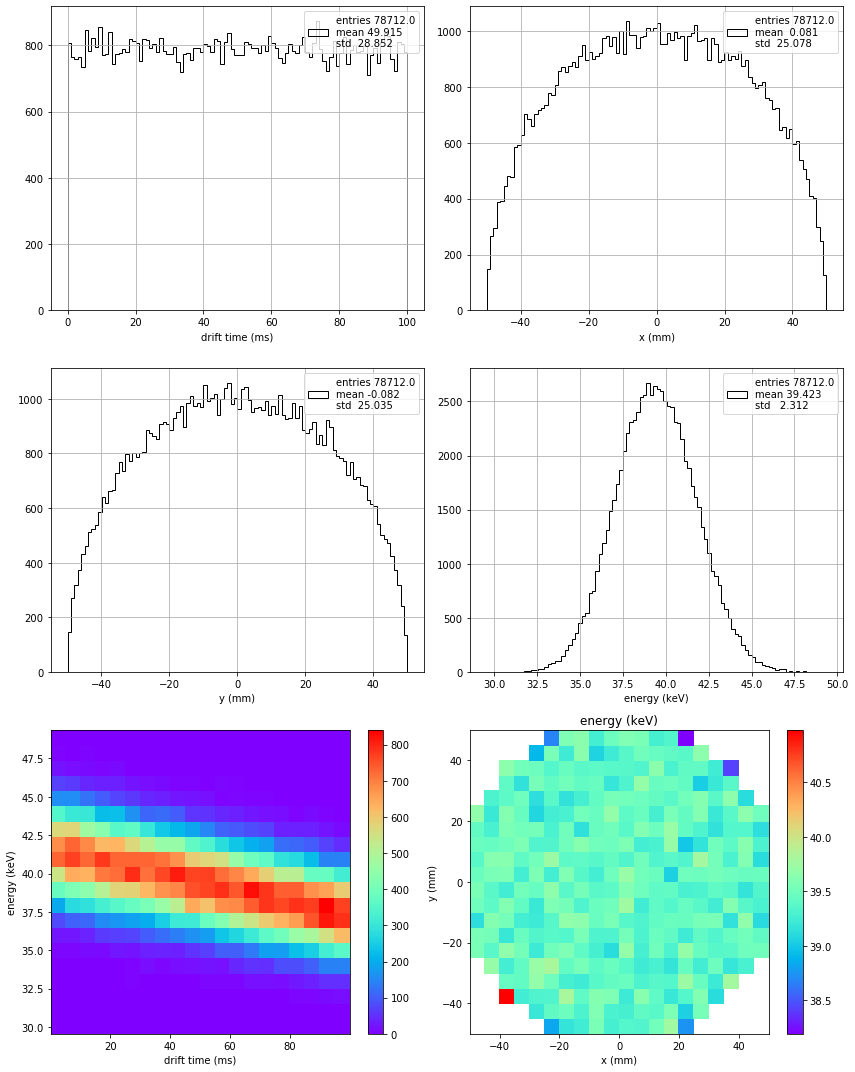

In [11]:
plot_data(df)

In [12]:
coors  = (df.dtime.values,)
energy = df.energy.values
bins   = 100
krmap  = compute_krmap(coors, energy, bins)

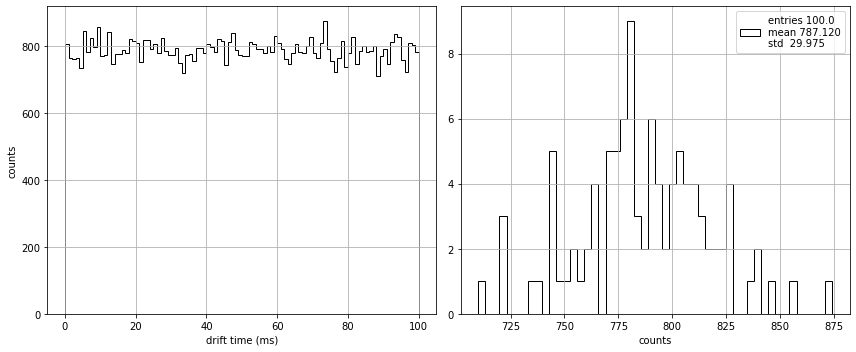

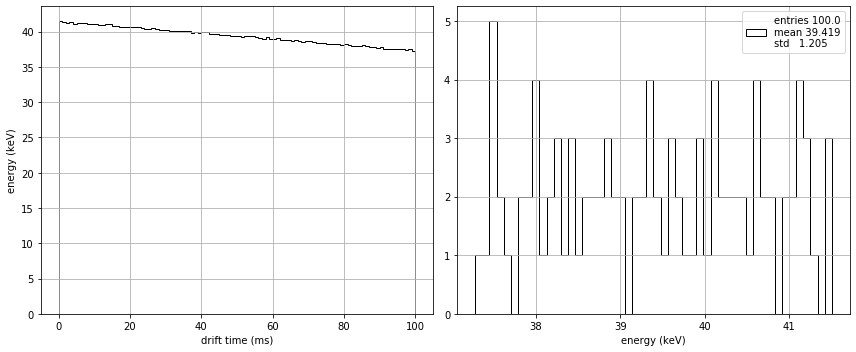

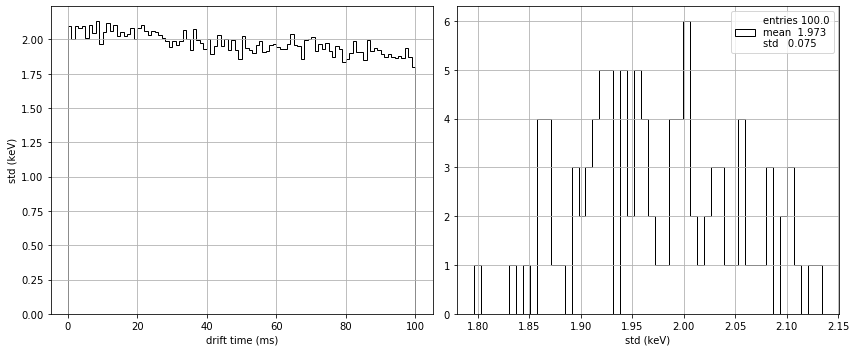

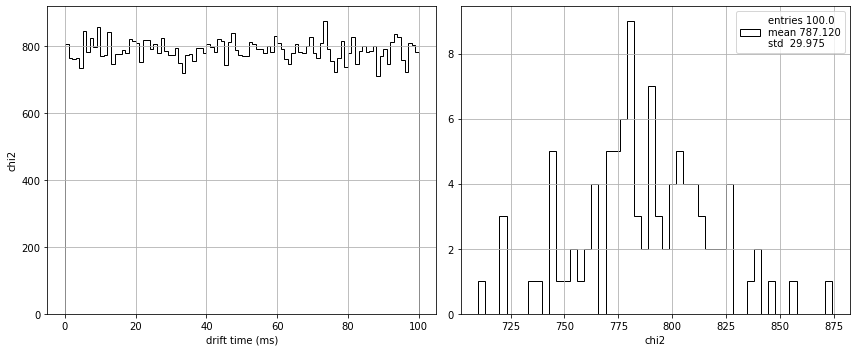

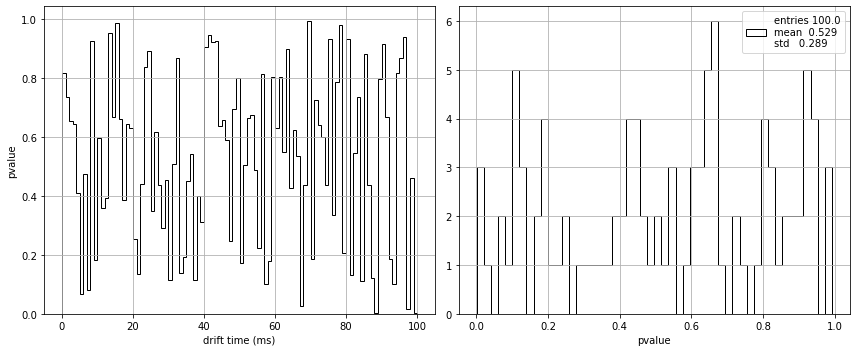

In [13]:
plot_krmap(krmap)

### correction

In [14]:
corenergy = krmap_correction(coors, energy, krmap)
corkrmap  = compute_krmap(coors, corenergy, bins)

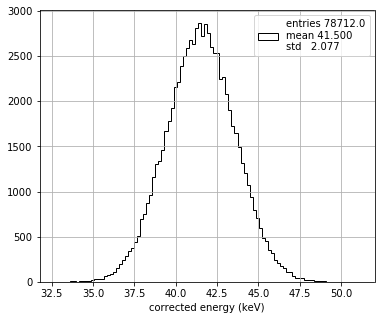

In [15]:
pltext.canvas(1, 1)
pltext.hist(corenergy, 100);
plt.xlabel('corrected energy (keV)');

### Validate correction

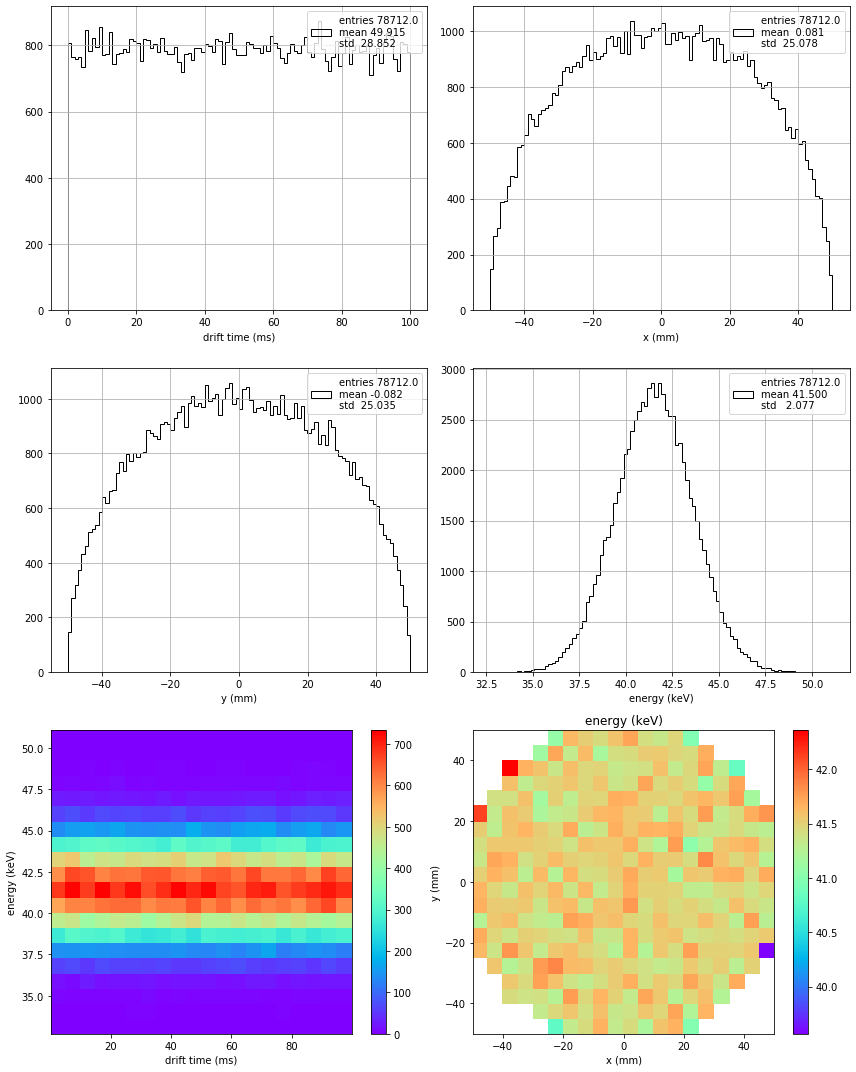

In [16]:
xdf = pd.DataFrame(df) 
xdf['energy'] = corenergy
plot_data(xdf)

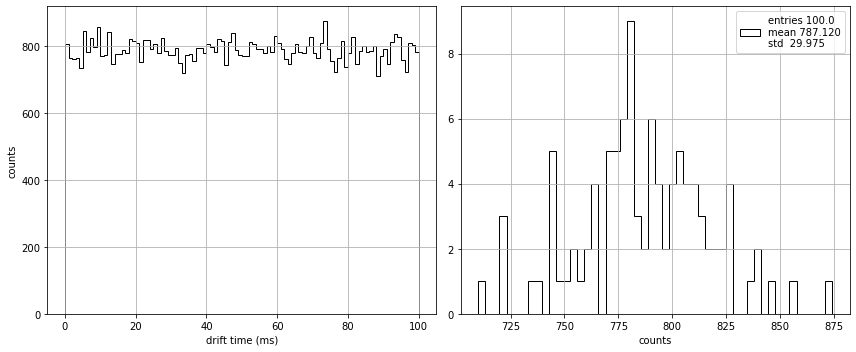

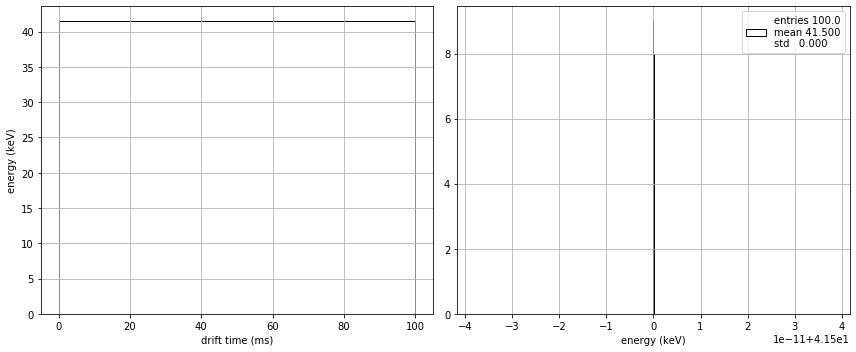

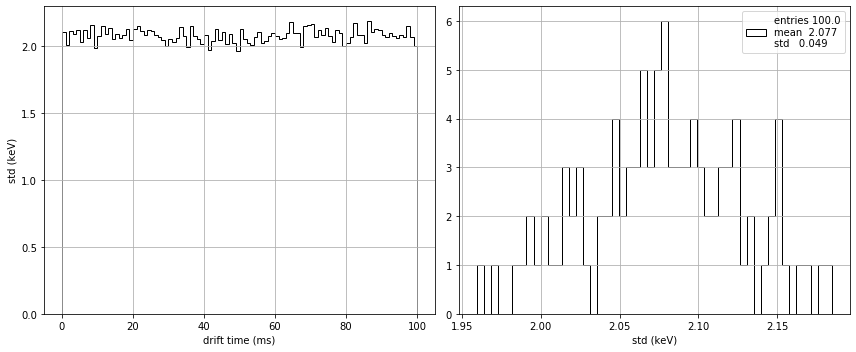

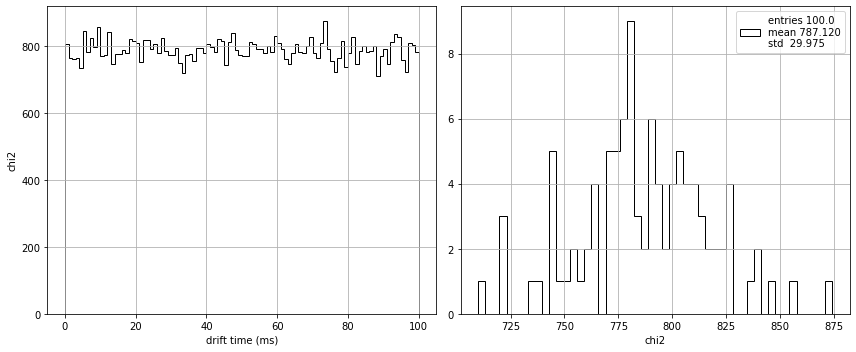

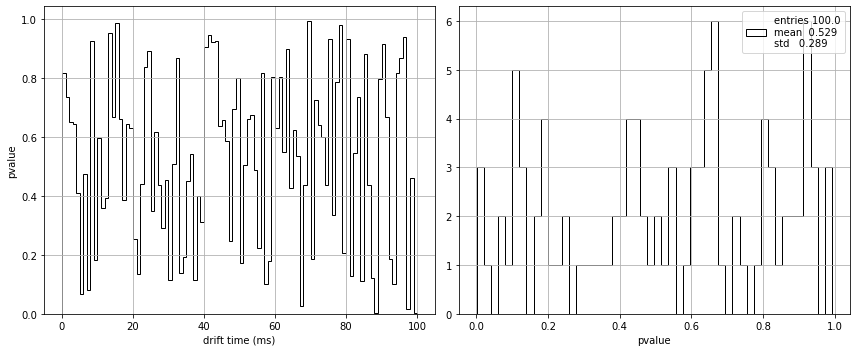

In [17]:
plot_krmap(corkrmap)

## 2D

In [18]:
df = generate_kr_toy(100000, tau = 0., beta = 0.2)
df

,dtime,x,y,energy
0,2.286021,-34.284848,16.947402,37.744419
1,10.628203,36.401481,-18.088084,32.878053
2,5.914586,-27.966808,14.080582,41.204549
3,86.639119,-24.570115,5.965611,36.382689
4,26.928597,-37.515577,3.243390,36.468077
...,...,...,...,...
78539,36.632740,-3.412339,-6.119878,38.242229
78540,22.066282,-15.472631,38.574815,32.543052
78541,13.654762,1.935196,12.594940,41.764243
78542,20.784120,28.441232,34.483716,34.308739


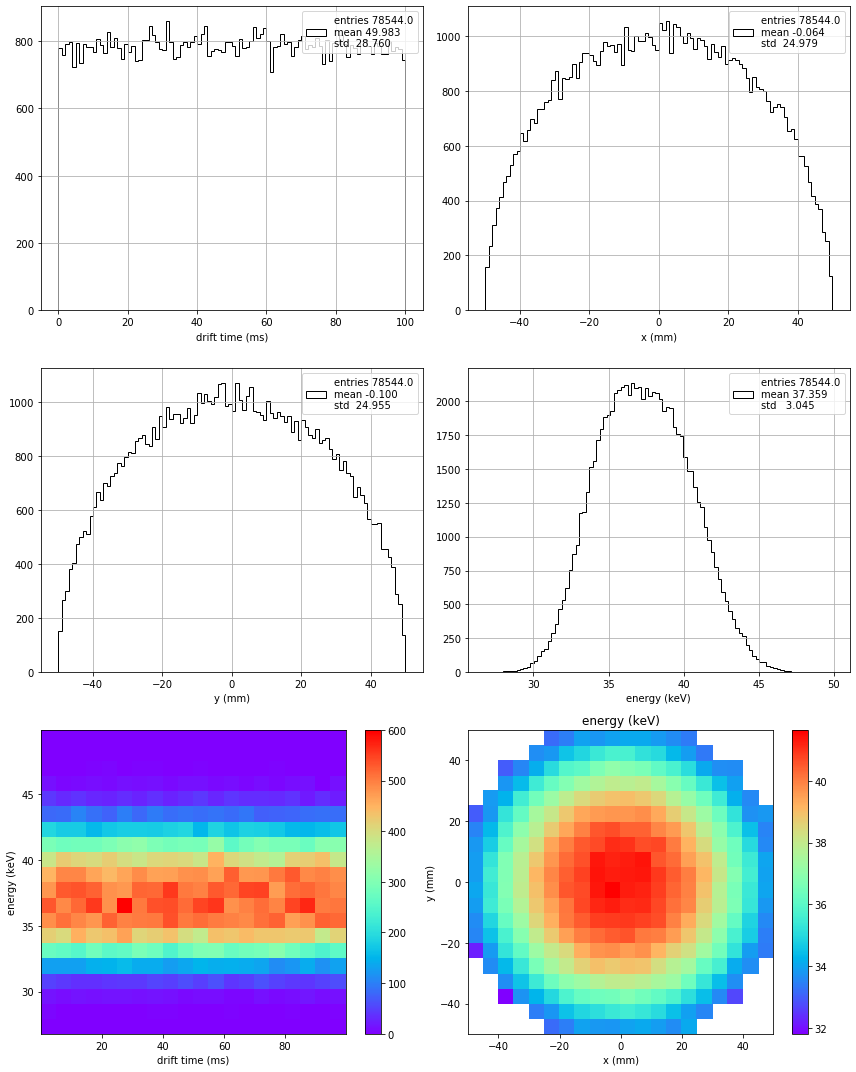

In [19]:
plot_data(df)

### kr  map

In [20]:
coors  = (df.x.values, df.y.values)
energy = df.energy.values
bins   = 40, 40
krmap  = compute_krmap(coors, energy, bins)

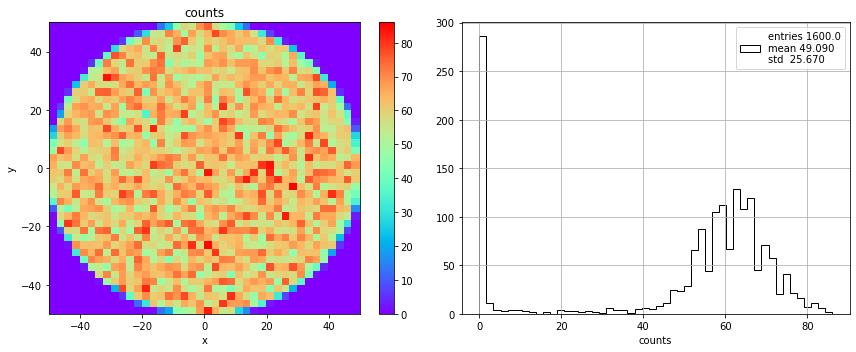

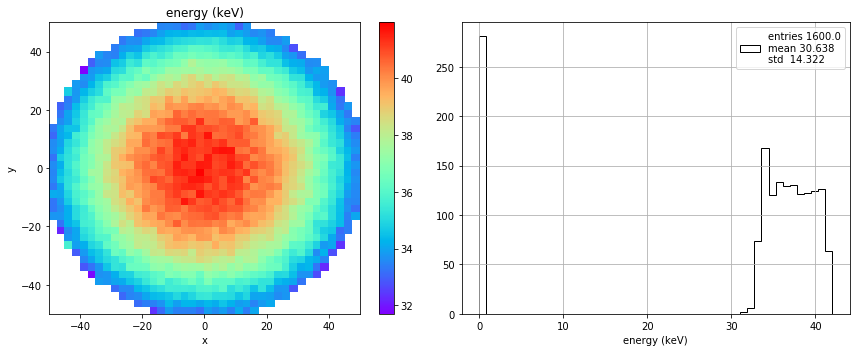

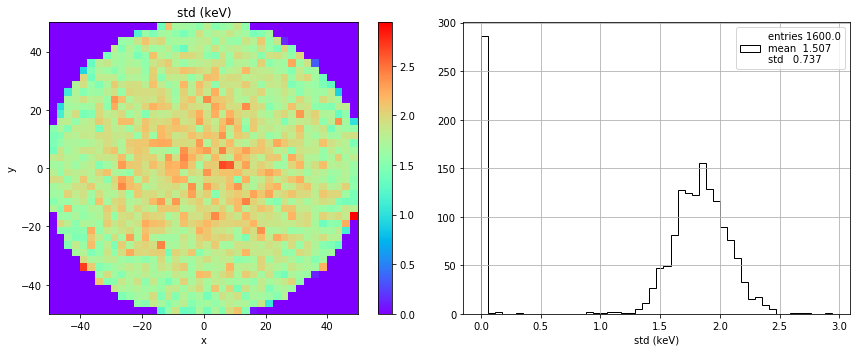

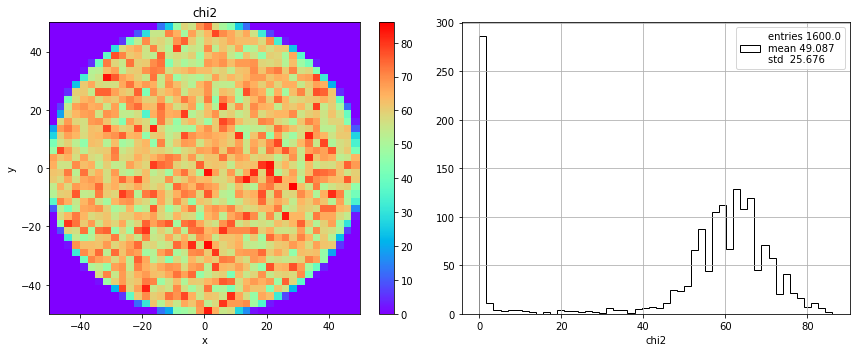

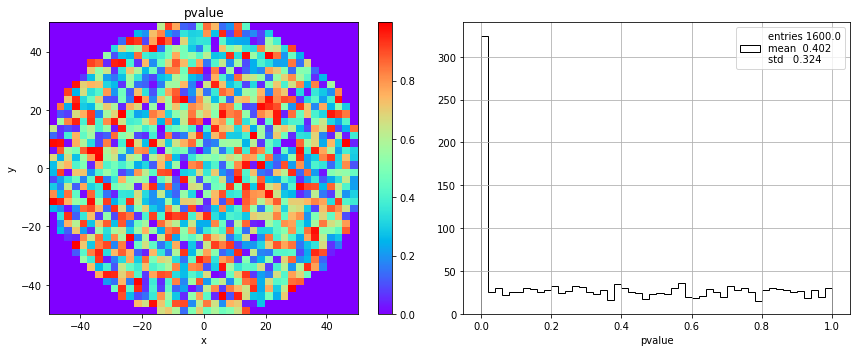

In [21]:
plot_krmap(krmap)

### Correction

In [22]:
corenergy = krmap_correction(coors, energy, krmap)
corkrmap  = compute_krmap(coors, corenergy, bins)

Text(0.5, 0, 'corrected energy (keV)')

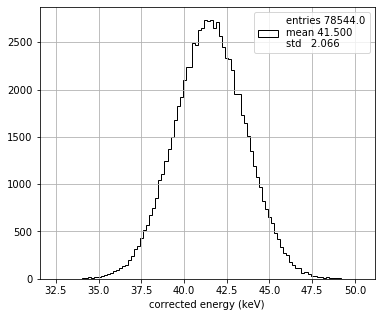

In [23]:
pltext.canvas(1, 1)
pltext.hist(corenergy, 100);
plt.xlabel('corrected energy (keV)')

### Validate correction

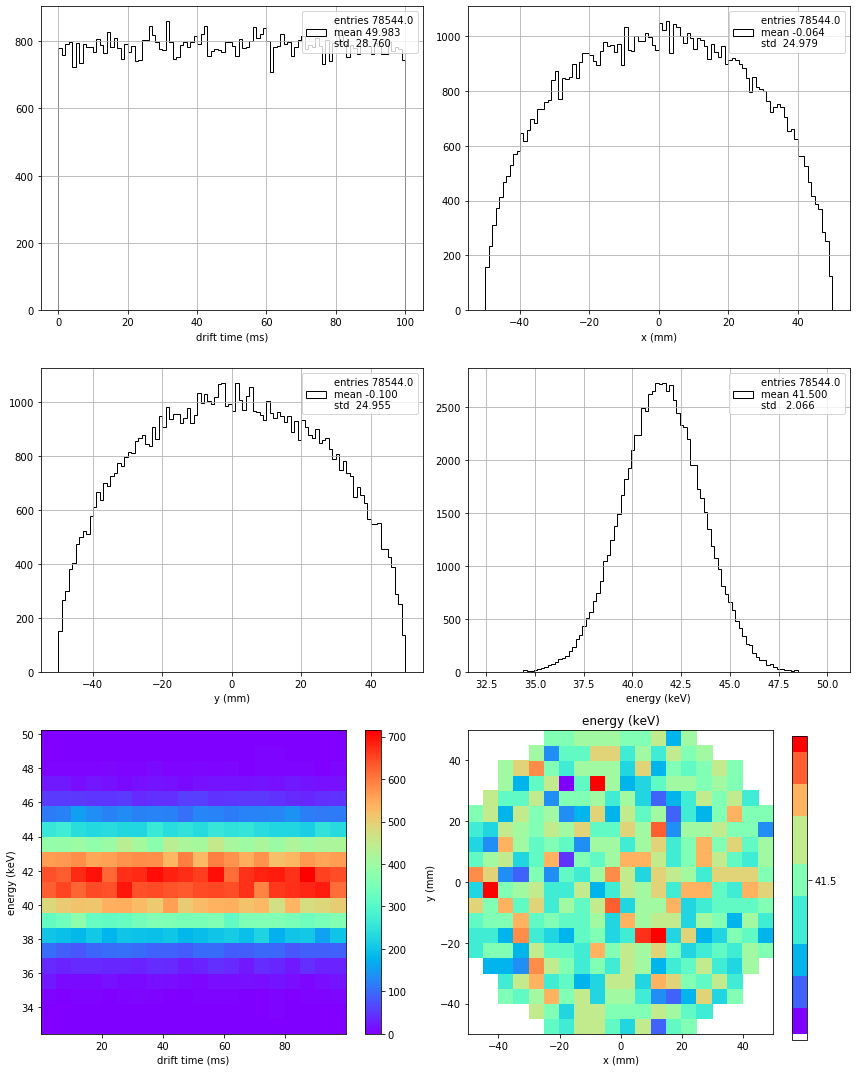

In [24]:
xdf = pd.DataFrame(df) 
xdf['energy'] = corenergy
plot_data(xdf)

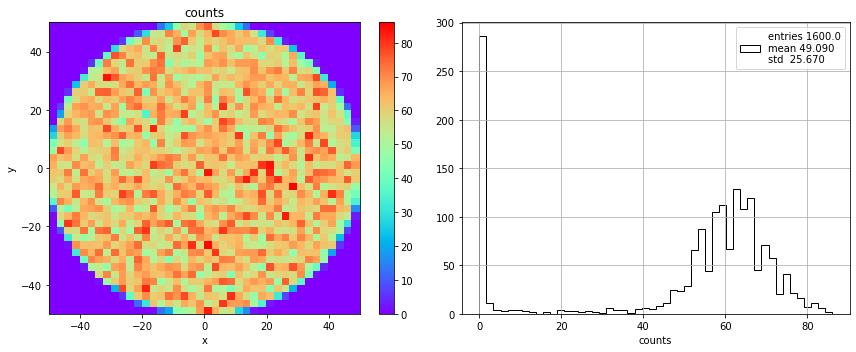

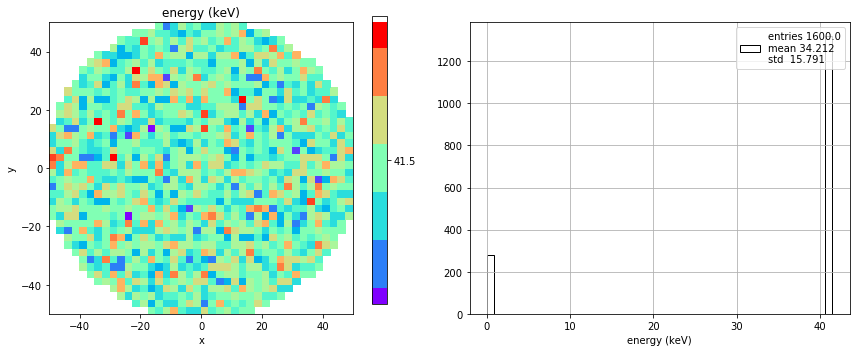

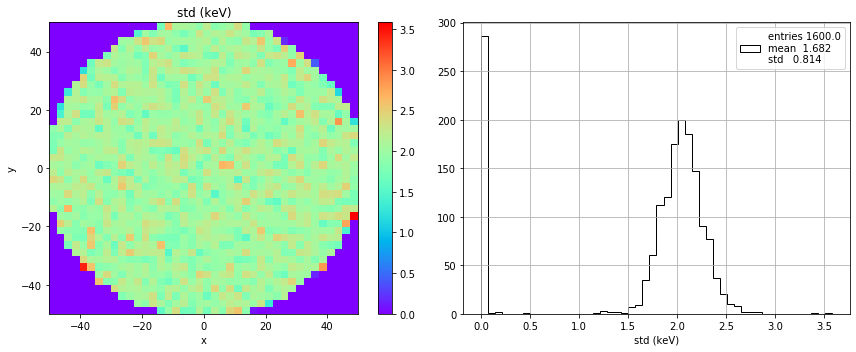

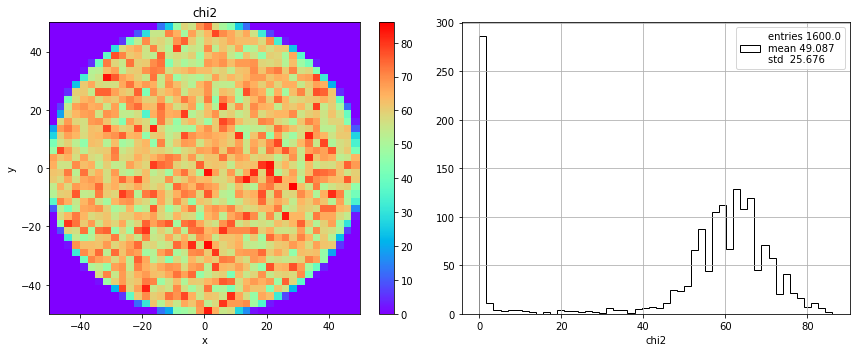

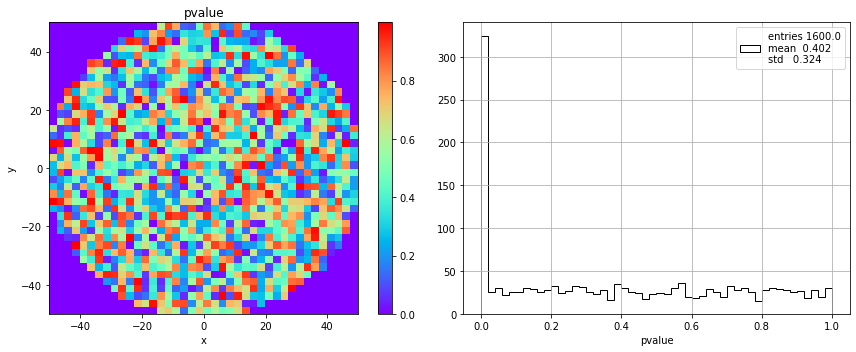

In [25]:
plot_krmap(corkrmap)

## 3D

In [26]:
df = generate_kr_toy(100000, tau = 0.1, beta = 0.2)
df

,dtime,x,y,energy
0,58.889464,8.418569,-42.320978,34.361339
1,9.006362,19.939169,-2.166398,42.511919
2,50.204354,-10.315749,7.291874,36.923820
3,24.992175,40.512697,3.169064,36.481186
4,72.766799,-29.282358,6.764987,36.024854
...,...,...,...,...
78531,77.458654,-0.105719,24.421373,38.696320
78532,85.167847,-19.067855,-20.089031,36.974942
78533,66.704579,15.054944,-43.689336,31.001871
78534,71.311787,-29.214140,-30.664137,32.359013


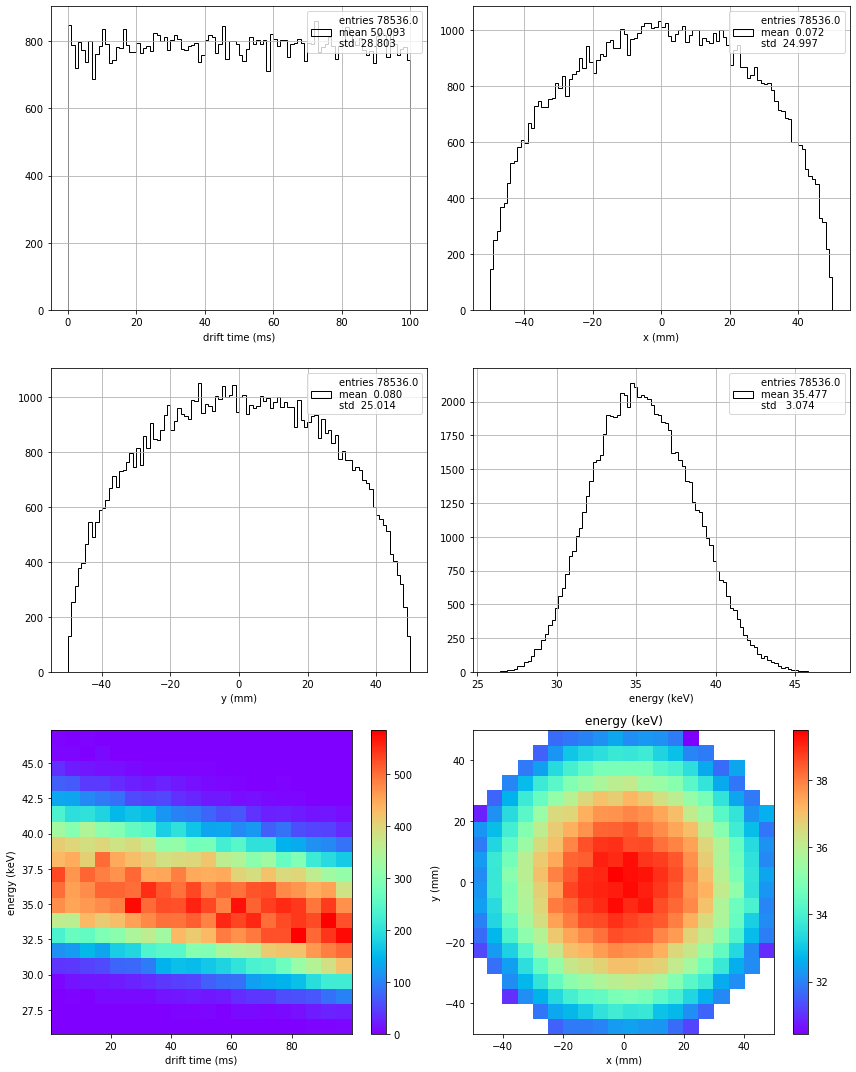

In [27]:
plot_data(df)

### Kr map

In [28]:
coors  = (df.x.values, df.y.values, df.dtime.values)
energy = df.energy.values
bins   = 20, 20, 4
krmap  = compute_krmap(coors, energy, bins)

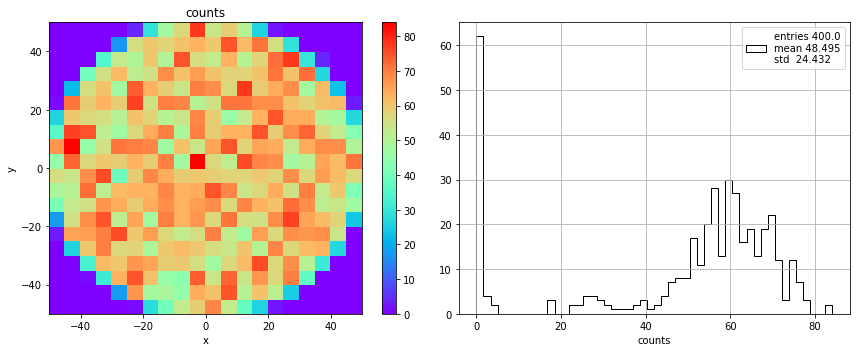

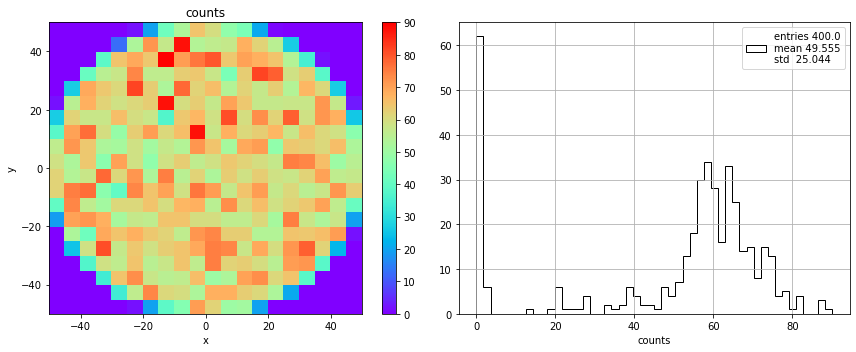

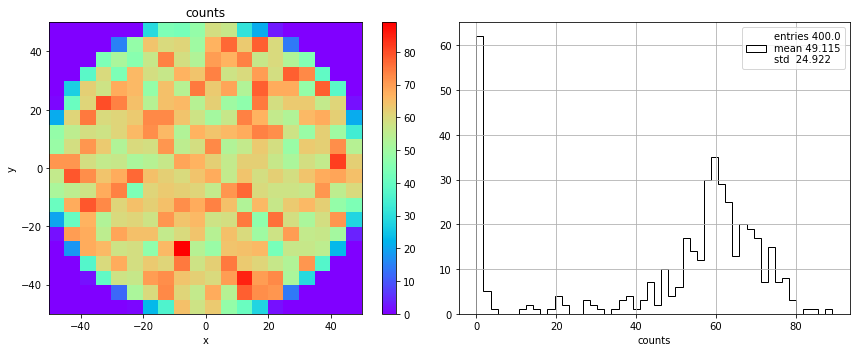

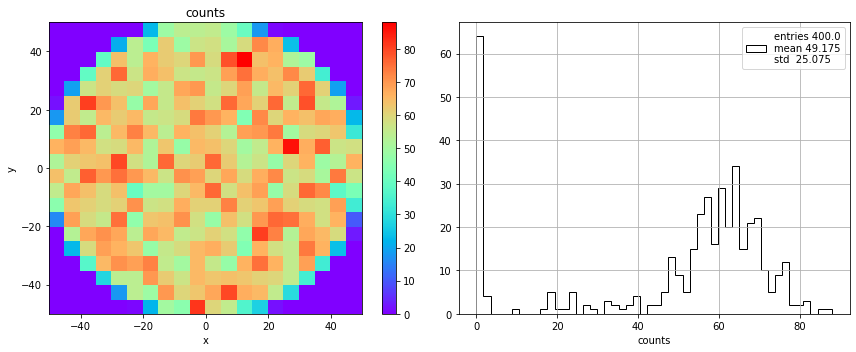

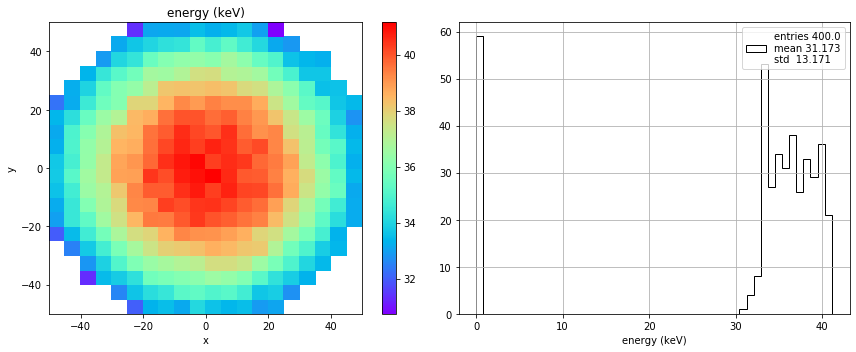

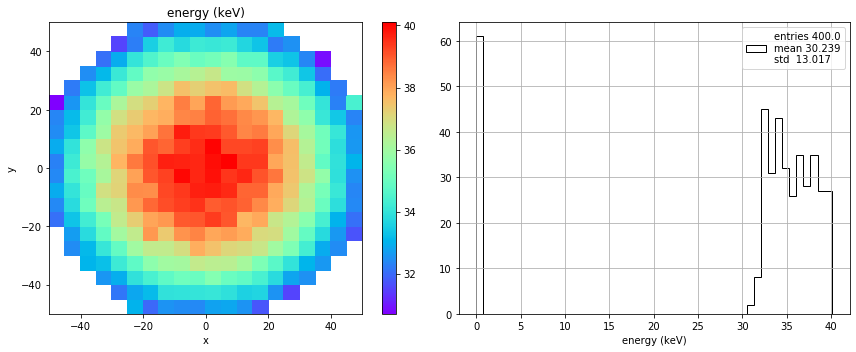

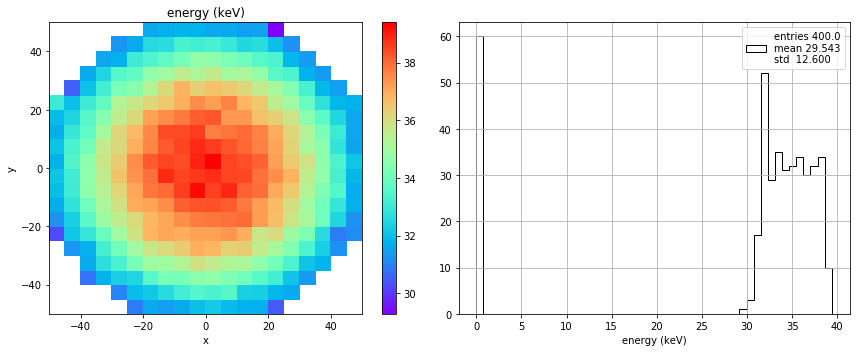

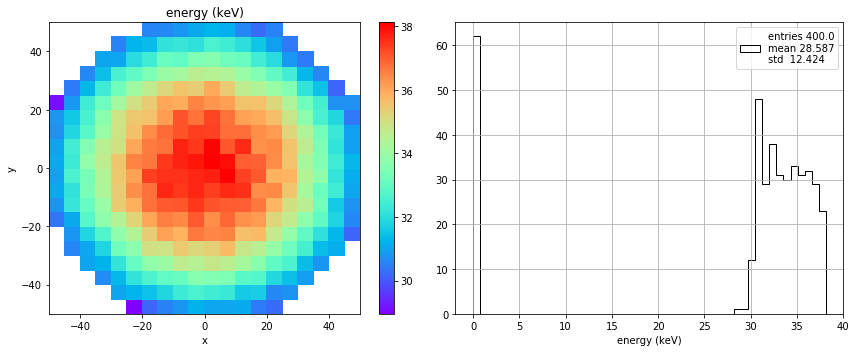

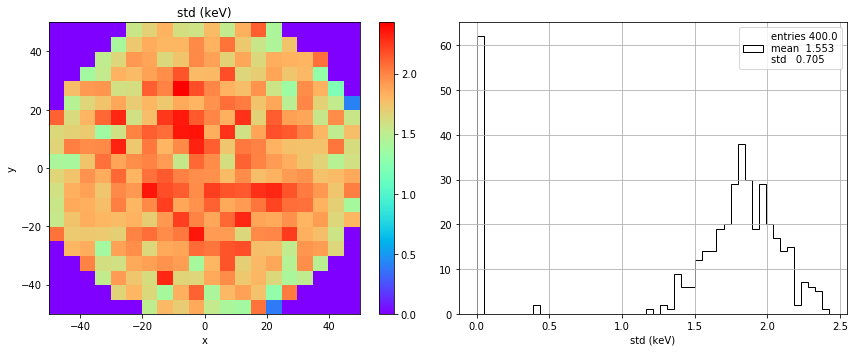

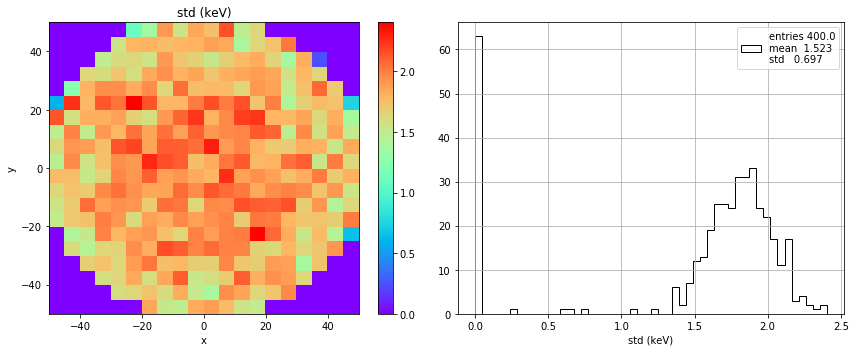

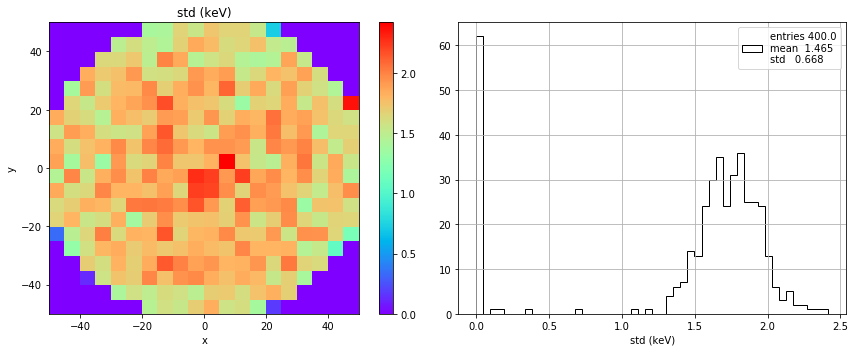

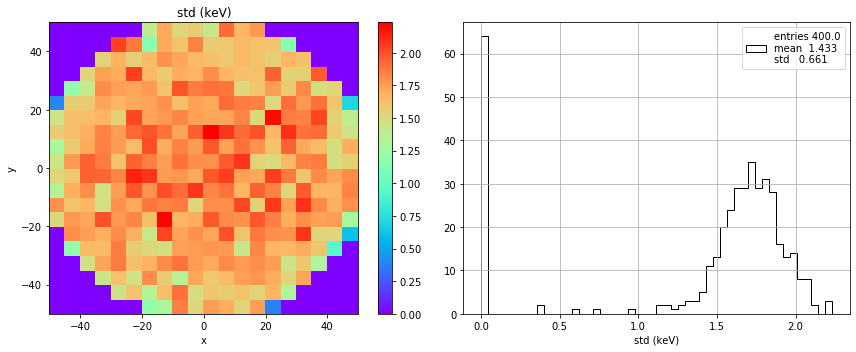

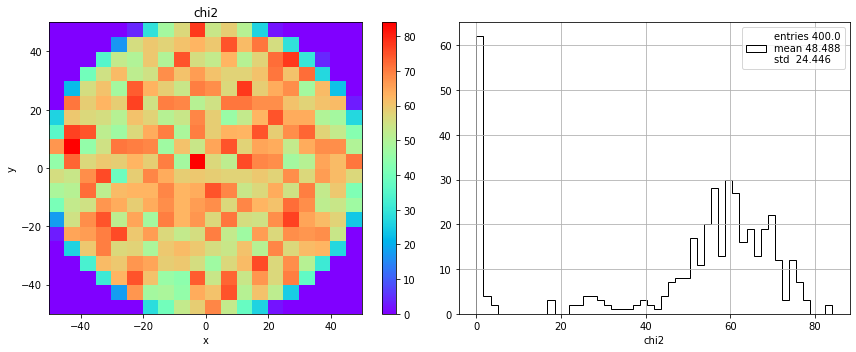

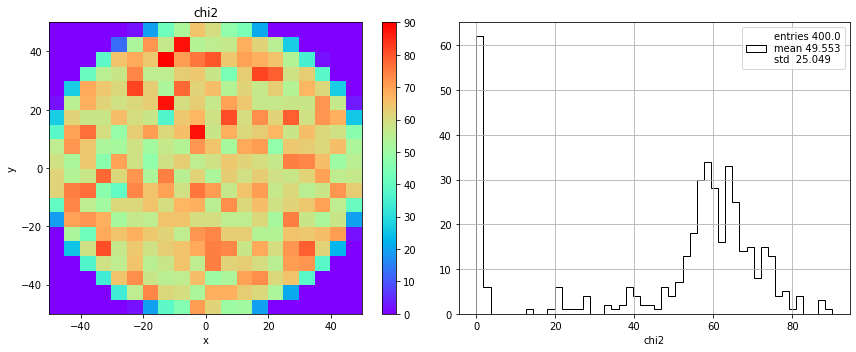

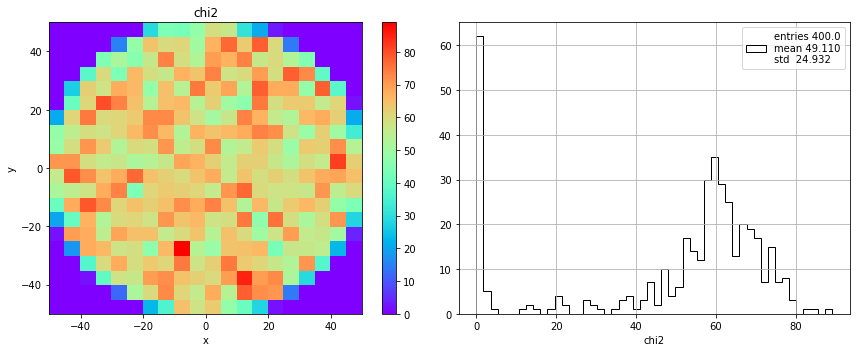

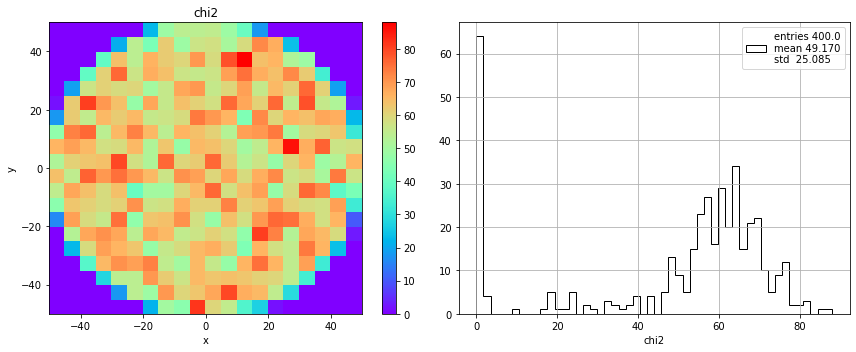

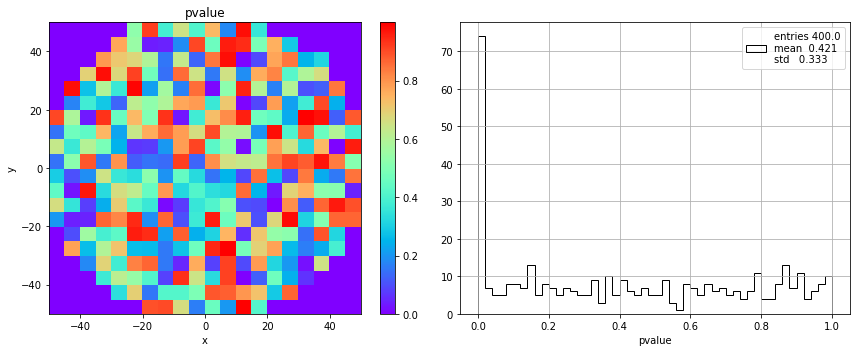

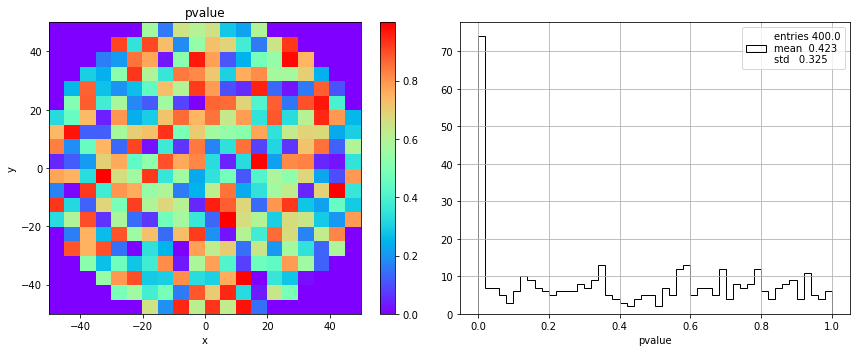

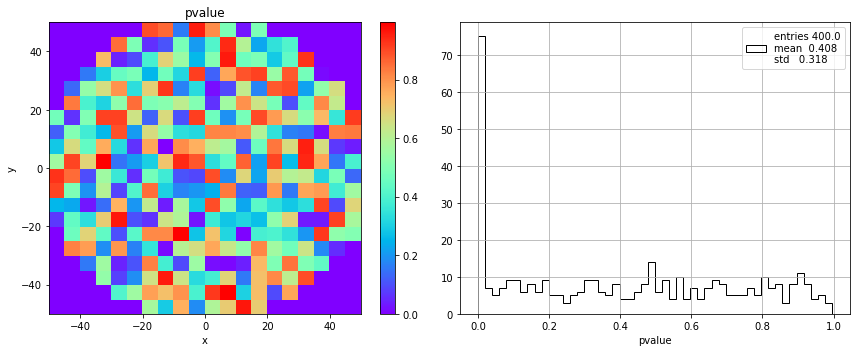

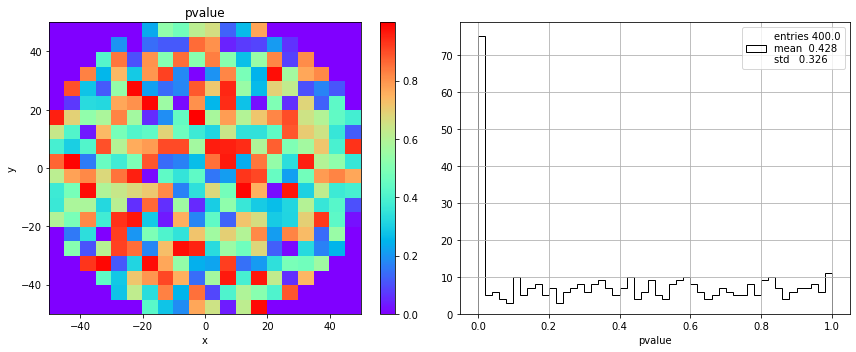

In [29]:
plot_krmap(krmap)

### corrections

In [30]:
corenergy = krmap_correction(coors, energy, krmap)
corkrmap  = compute_krmap(coors, corenergy, bins)

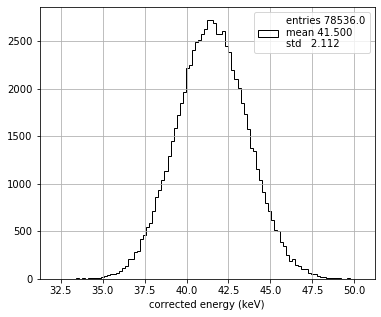

In [31]:
pltext.canvas(1, 1)
pltext.hist(corenergy, 100);
plt.xlabel('corrected energy (keV)');

### Validate correction

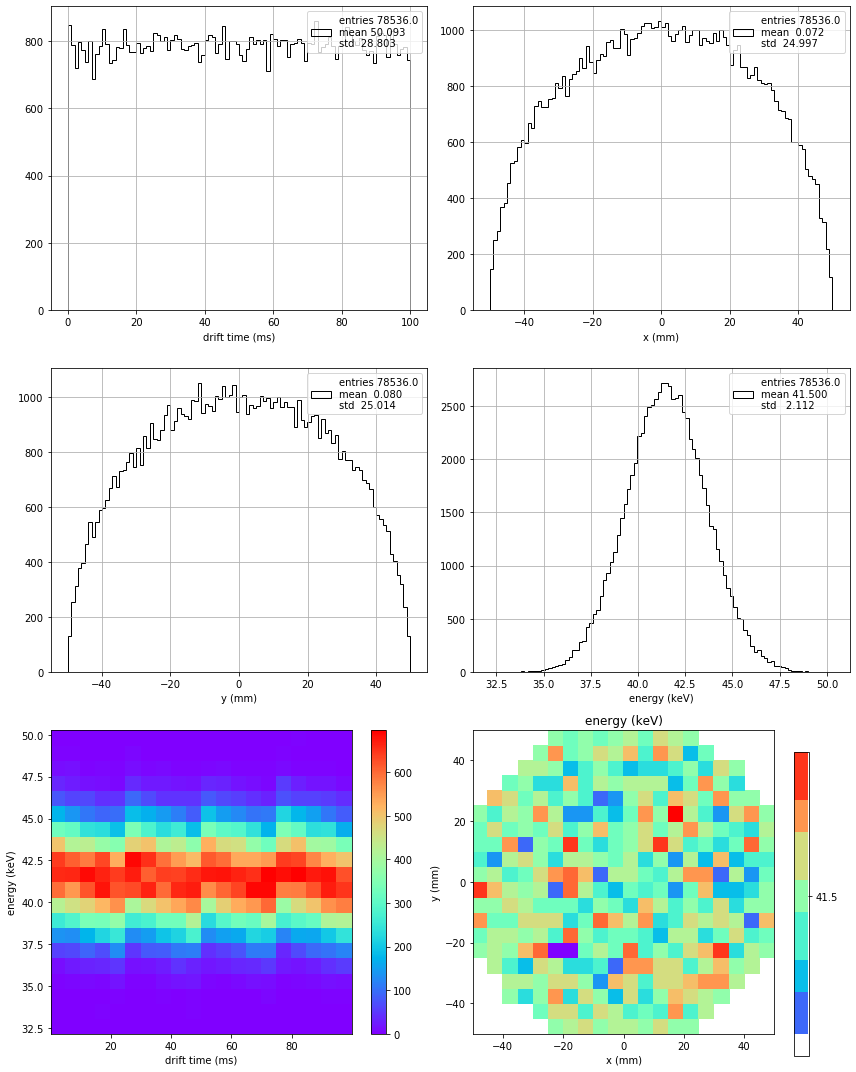

In [32]:
xdf = pd.DataFrame(df) 
xdf['energy'] = corenergy
plot_data(xdf)

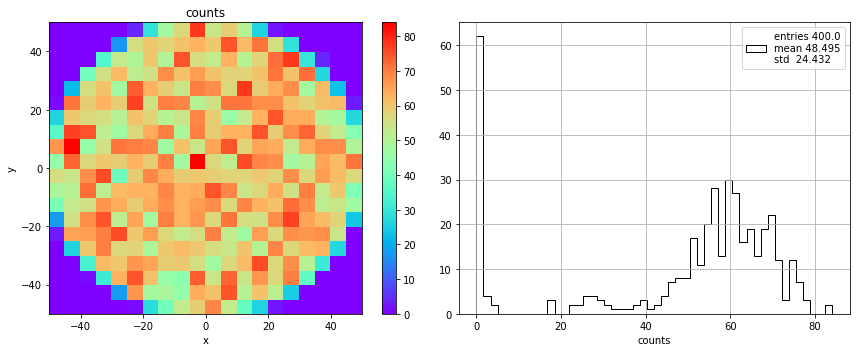

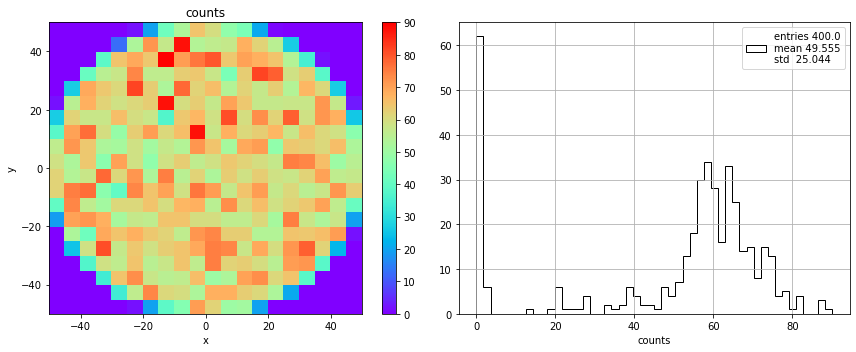

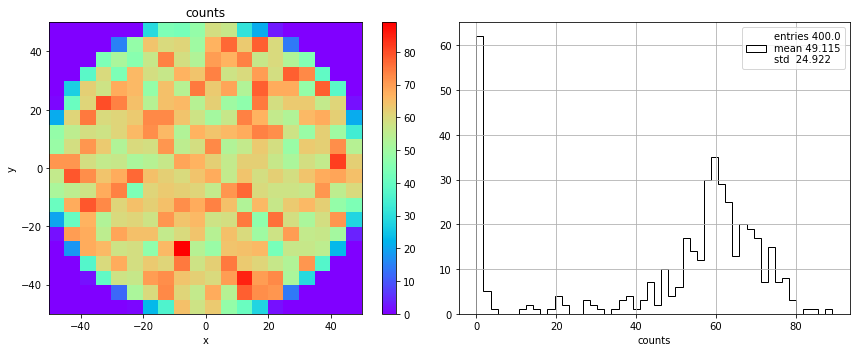

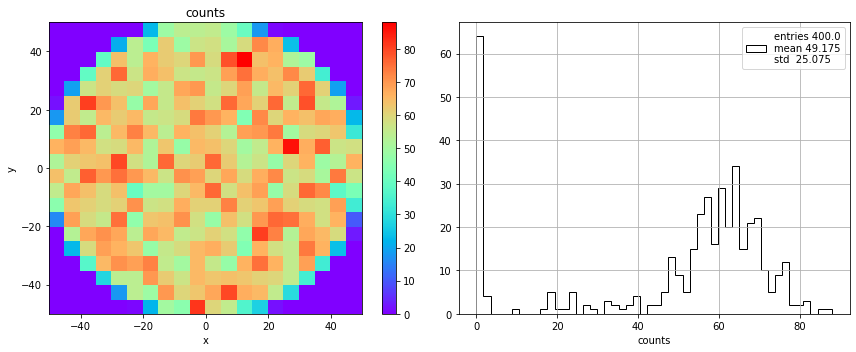

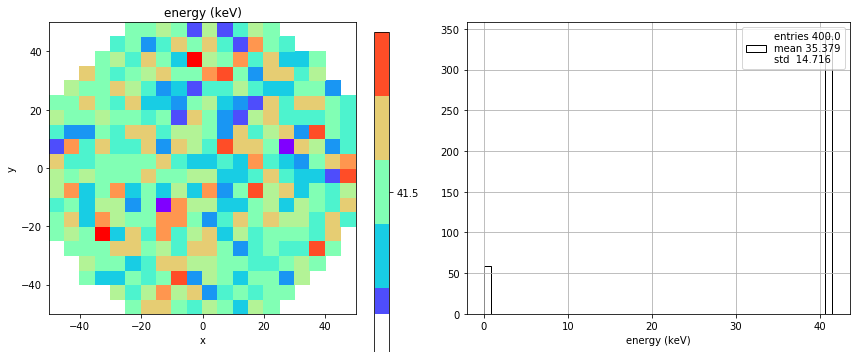

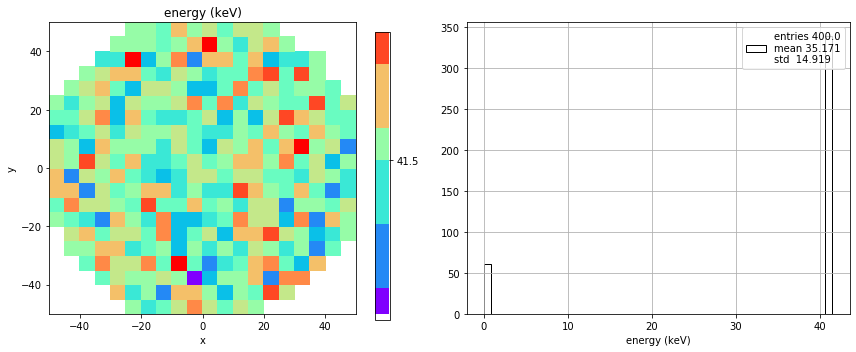

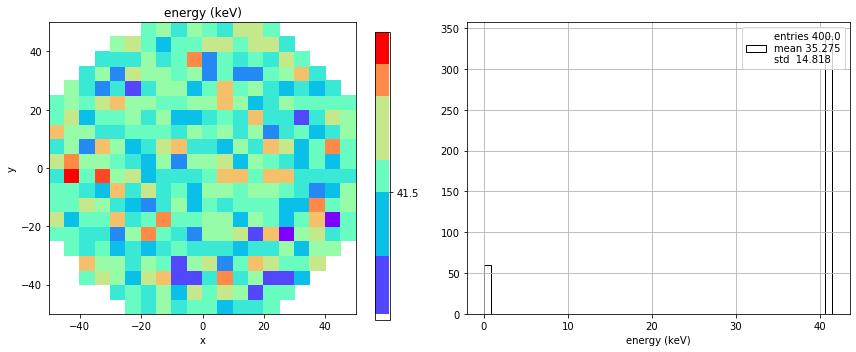

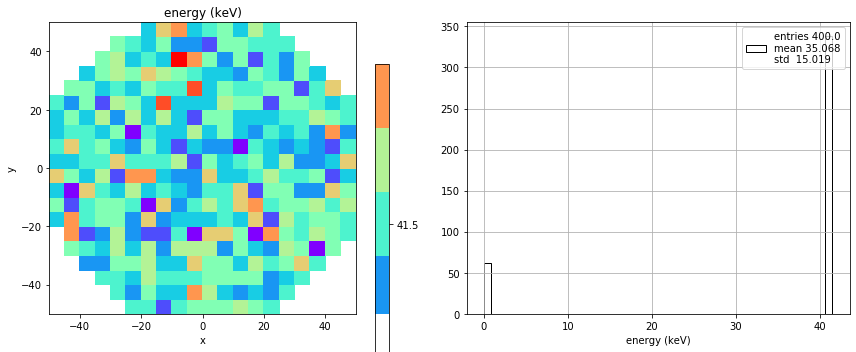

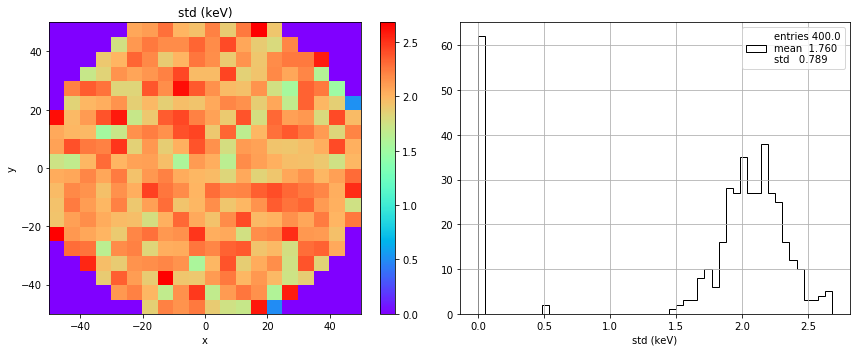

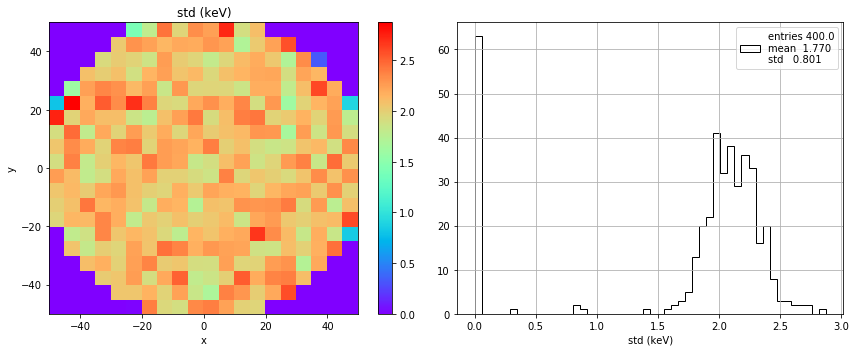

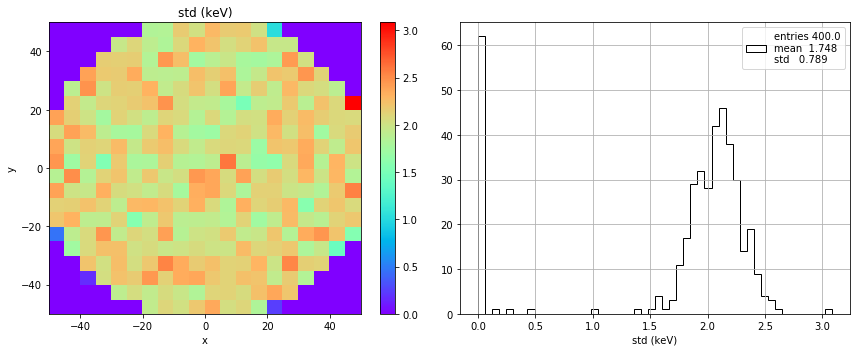

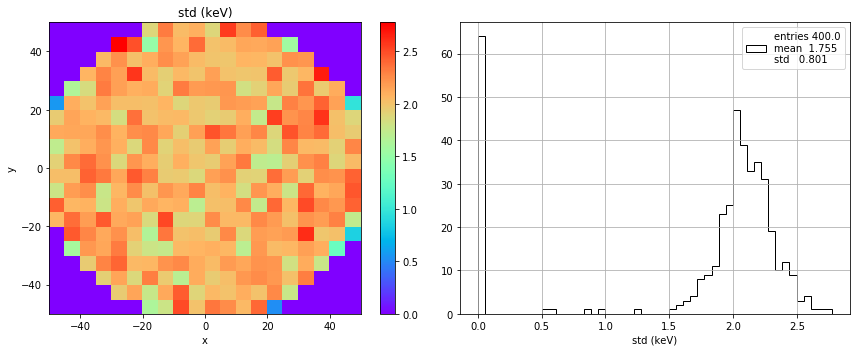

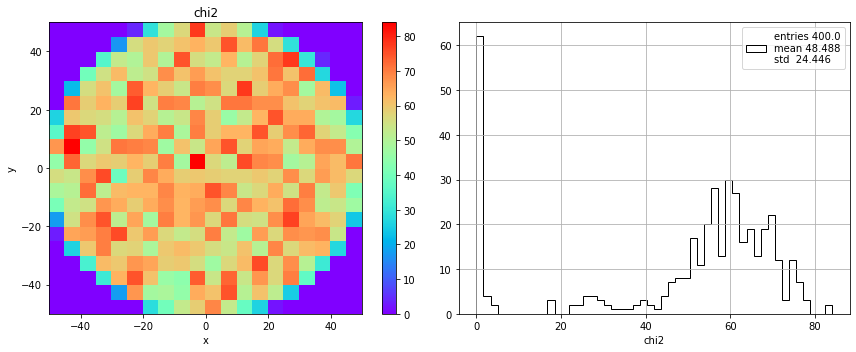

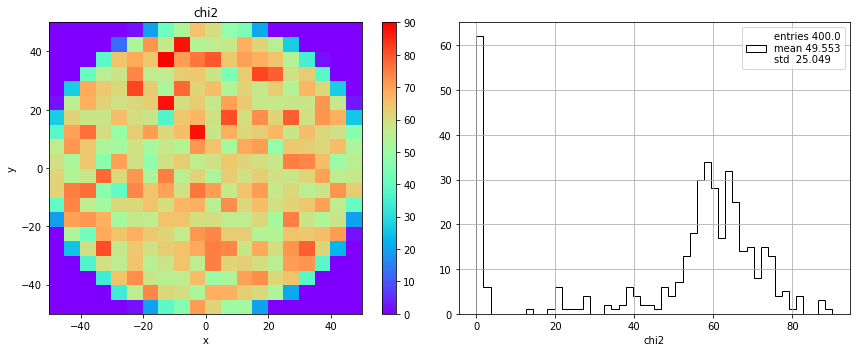

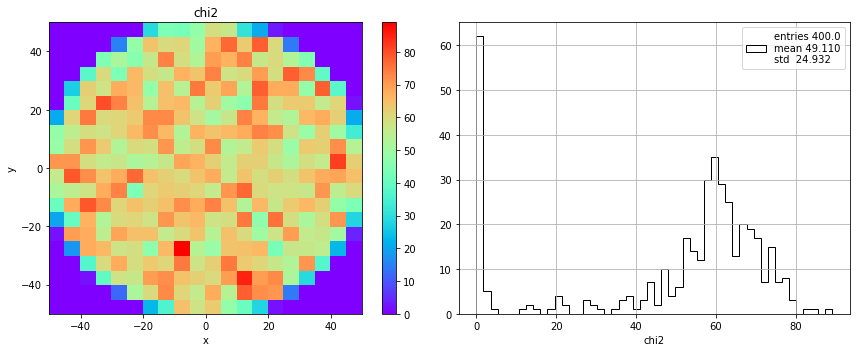

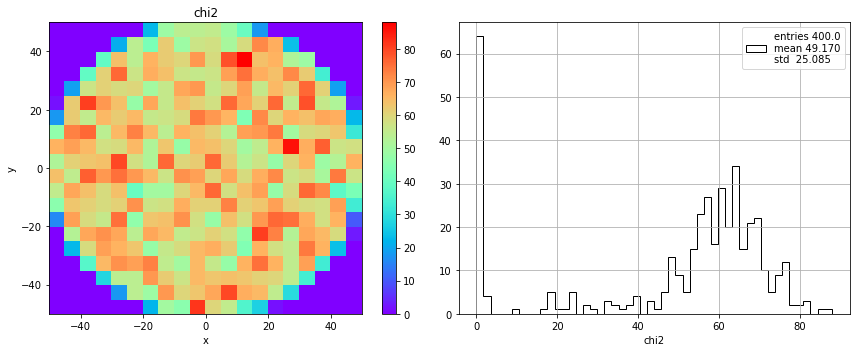

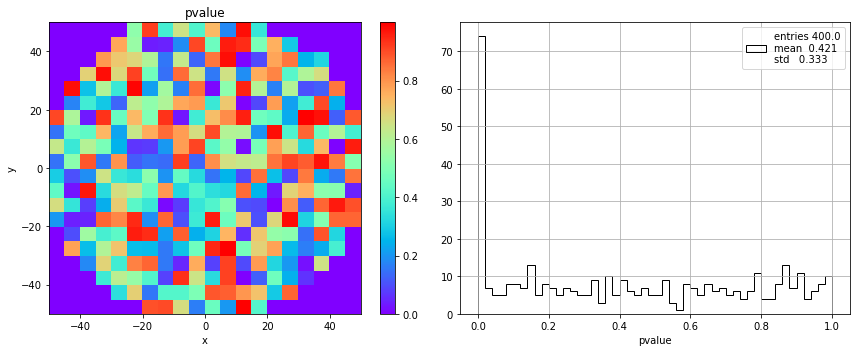

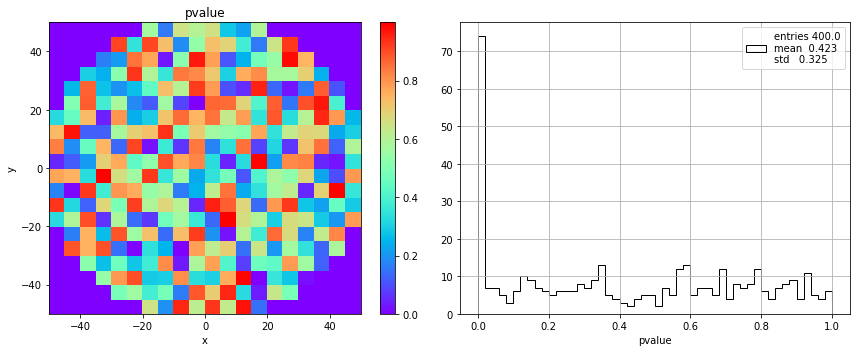

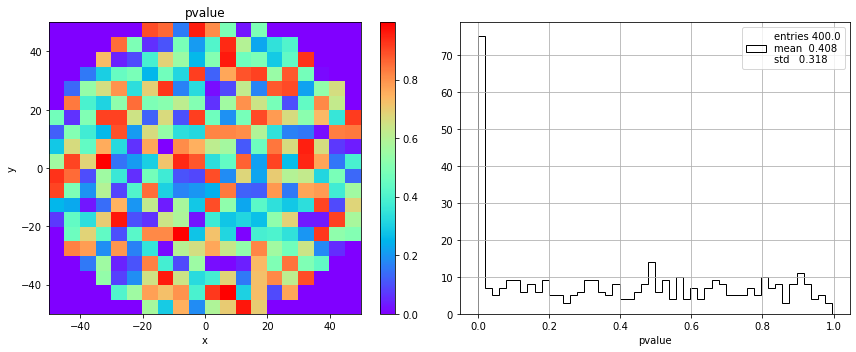

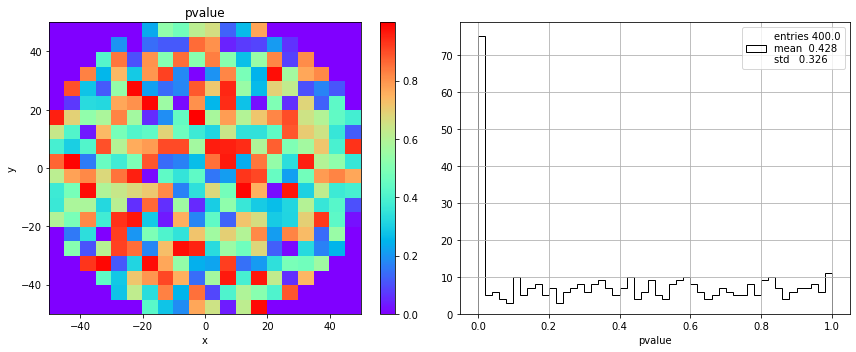

In [33]:
plot_krmap(corkrmap)